In [310]:
import numpy as np

In [311]:
import pandas as pd

In [312]:
import operator

In [313]:
import random

In [314]:
import time

In [315]:
from IPython.display import Image

In [316]:
import matplotlib
from matplotlib import pyplot as plt

In [317]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance_to(self, city):
        x_distance = abs(self.x - city.x)
        y_distance = abs(self.y - city.y)
        distance = np.sqrt(x_distance ** 2 + y_distance ** 2)
        return distance
    
    def __repr__(self):
        return str(self.x) + ', ' + str(self.y) + '\n'

In [318]:
class Graph:
    def __init__(self):
        self.graph = np.array([], dtype=City)
    
    def add_city(self, city):
        self.graph = np.append(self.graph, city)
        
    def get_city(self, index):
        return self.graph[index]
    
    def get_graph(self):
        return self.graph
    
    def __len__(self):
        return len(self.graph)

In [319]:
class Route:
    def __init__(self, graph_array, initial):
        self.distance = 0
        self.fitness = 0

        self.route = graph_array

        if initial:
            np.random.shuffle(self.route)
        
    def __len__(self):
        return len(self.route)
        
    def get_city(self, index):
        return self.route[index]
    
    def set_city(self, index, city):
        self.route[index] = city
        
    def contains(self, city):
        return city in self.route
    
    def get_distance(self):
        if self.distance == 0:
            for i in range(len(self) - 1):
                self.distance += self.route[i].distance_to(self.route[i + 1])
            self.distance += self.get_city(len(self) - 1).distance_to(self.get_city(0))
            
        return self.distance
    
    def get_fitness(self):
        if self.fitness == 0:
            self.fitness = 1.0 / self.get_distance()
            
        return self.fitness

In [320]:
class Population:
    def __init__(self, graph_array, population_size, initial):
        self.population_size = population_size

        if type(graph_array[0]) == City:
            pop = []

            for i in range(self.population_size):
                route = Route(graph_array, initial)
                route.get_distance()
                pop.append(route)

            self.routes = np.array(pop, dtype=Route)
        else:
            self.routes = graph_array
    
    def __len__(self):
        return self.population_size
        
    def get_route(self, index):
        return self.routes[index]
    
    def set_route(self, index, route):
        self.routes[index] = route

    def get_fittest(self):
        fittest = self.routes[0]
        
        for i in range(self.population_size):
            if fittest.get_fitness() <= self.routes[i].get_fitness():
                fittest = self.routes[i]
        
        return fittest
    
    def ranked_routes(self):
        fitness_results = {}
        for i in range(len(self)):
            fitness_results[i] = self.routes[i].get_fitness()
        return sorted(fitness_results.items(), key = operator.itemgetter(1), reverse = True)

In [321]:
class GA:
    def __init__(self, graph):
        self.graph = graph
        
    def selection(self, ranked, elitism_size):
        selection = np.array([], dtype=Route)
        
        df = pd.DataFrame(np.array(ranked), columns=["Index", "Fitness"])
        df['cum_sum'] = df.Fitness.cumsum()
        df['cum_perc'] = 100 * df.cum_sum / df.Fitness.sum()

        # bruh
        for i in range(len(ranked)):
            selection = np.append(selection, ranked[i][0])
                    
        return selection
    
    def mating_pool(self, population, selection):
        mating_pool = np.array([], dtype=Route)
        
        for index in selection:
            mating_pool = np.append(mating_pool, population.get_route(index))
            
        return mating_pool
    
    def crossover(self, parent1, parent2):
        childP1 = []
        childP2 = []
        
        start = int(np.random.rand() * len(parent1))
        end = int(np.random.rand() * len(parent1))
        
        if start > end:
            start, end = end, start
        
        for i in range(start, end):
            childP1.append(parent1.get_city(i))
        
        childP2 = [item for item in parent2.route if item not in childP1]
        
        child = Route(childP1 + childP2, False)
        child.get_distance()

        return child
        
    def breed_population(self, mating_pool, elitism_size):
        children = np.array([], dtype=Route)
        length = len(mating_pool) - elitism_size
        pool = random.sample(list(mating_pool), len(mating_pool))
        
        for i in range(elitism_size):
            children = np.append(children, mating_pool[i])
            
        for i in range(length):
            child = self.crossover(pool[i], pool[len(mating_pool) - i - 1])
            children = np.append(children, child)
            
        return children
    
    def mutate(self, route, mutation_rate):
        for swapped in range(len(route)):
            if np.random.rand() < mutation_rate:
                swap_with = int(np.random.rand() * len(route))
                
                city1 = route.get_city(swapped)
                city2 = route.get_city(swap_with)
                
                route.set_city(swapped, city2)
                route.set_city(swap_with, city1)

                route.distance = 0
                route.fitness = 0
                route.get_distance()

        return route
    
    def mutate_population(self, population, mutation_rate, elitism_size):
        mutated_population = np.array([], dtype=Route)
        
        for route in range(len(population)):
            if (route < elitism_size):
                mutated_population = np.append(mutated_population, population.get_route(route))
                continue
            mutated_route = self.mutate(population.get_route(route), mutation_rate)
            mutated_population = np.append(mutated_population, mutated_route)
        
        return mutated_population
    
    def evolve_population(self, population, elitism_size, mutation_rate):
        ranked_population = population.ranked_routes()
        selection = self.selection(ranked_population, elitism_size)
        mating_pool = self.mating_pool(population, selection)
        children = self.breed_population(mating_pool, elitism_size)
        next_generation = self.mutate_population(Population(children, len(children), False), mutation_rate, elitism_size)
        return list(next_generation)

In [327]:
if __name__ == "__main__":
    start_time = time.time()
    graph = Graph()
    
    with open('./data/dj38_data.tsp') as f:
        lines = f.readlines()
        for line in lines:
            coord = [float(x) for x in line.split()]
            city = City(coord[0], coord[1])
            graph.add_city(city)
    

    population_size = 500
    generations = 1000
    elitism_size = 100
    mutation_rate = 0.01
    
    population = Population(graph.get_graph(), population_size, True)
    
    ga = GA(population)

    data = [1 / population.ranked_routes()[0][1]]
    print("Initial Distance: " + str(data[0]))

    for i in range(generations):
        tmp = ga.evolve_population(population, elitism_size, mutation_rate)
        population = Population(tmp, len(tmp), False)
        data.append(1 / population.ranked_routes()[0][1])
    
    print("Final Distance: " + str(1 / population.ranked_routes()[0][1]))
    print("--- %s seconds ---" % (time.time() - start_time))

Initial Distance: 22590.13256948546
Final Distance: 6659.431532931463
--- 33.21976447105408 seconds ---


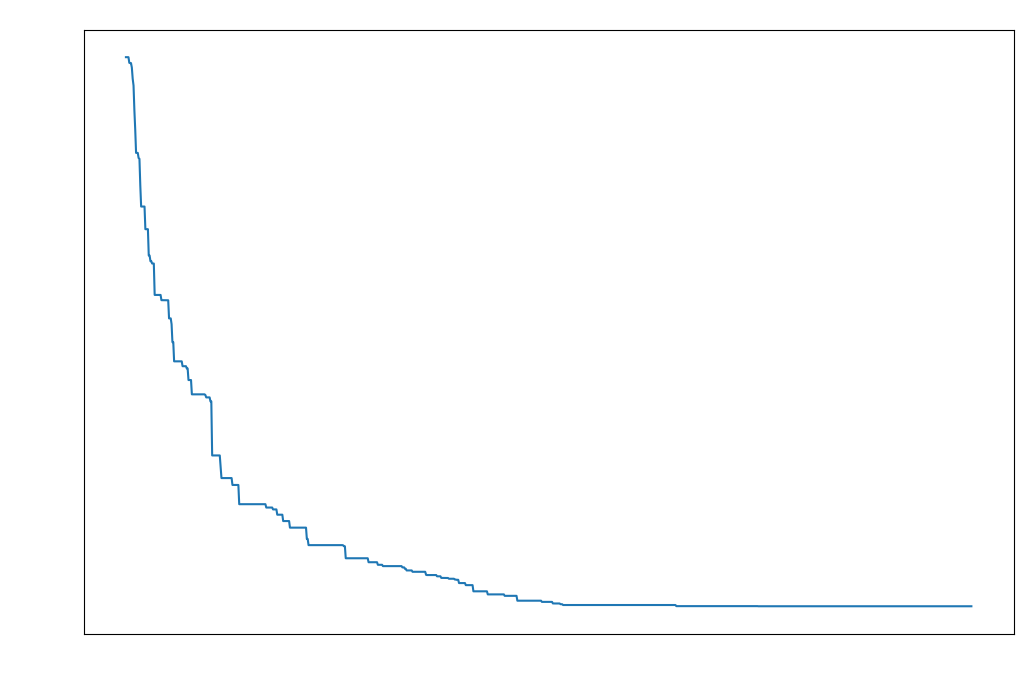

In [328]:
fig = plt.figure(figsize=(12,8), dpi= 100, edgecolor='w')
ax = fig.add_subplot(111)

ax.plot(data)
ax.set_title("Travelling Salesman - dj38")
ax.set_xlabel("Generation")
ax.set_ylabel("Distance")
ax.xaxis.label.set_color('w')
ax.yaxis.label.set_color('w')

plt.show()

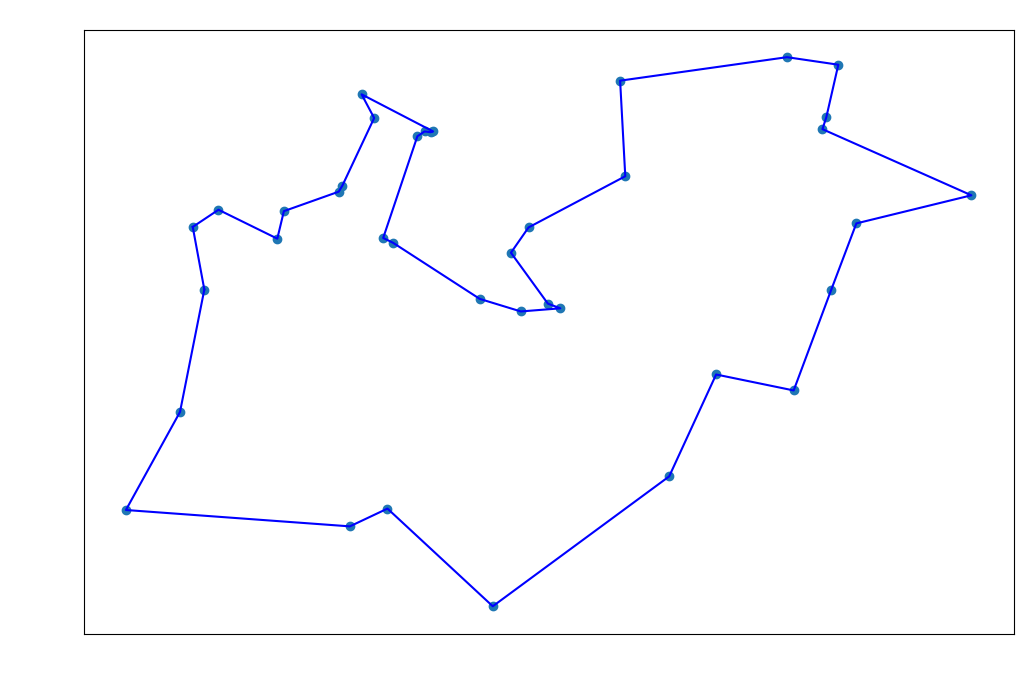

In [329]:
# Optimal Tour of dj38
# https://www.math.uwaterloo.ca/tsp/world/djtour.html
# This is an optimal tour for the dj38 TSP instance. It has length 6656.

# solution this genetic algorithm has found after 1000 generations
solution_found = population.get_route(population.ranked_routes()[0][0])

x = [i.x for i in solution_found.route]
y = [i.y for i in solution_found.route]

x1 = [x[0], x[-1]]
y1 = [y[0], y[-1]]

fig2 = plt.figure(figsize=(12,8), dpi= 100, edgecolor='w')
ax2 = fig2.add_subplot(111)

ax2.plot(x, y, 'b', x1, y1, 'b')
ax2.scatter(x, y)
ax2.set_title("Travelling Salesman - dj38")
ax2.set_xlabel("Generation")
ax2.set_ylabel("Distance")
ax2.xaxis.label.set_color('w')
ax2.yaxis.label.set_color('w')


plt.show()

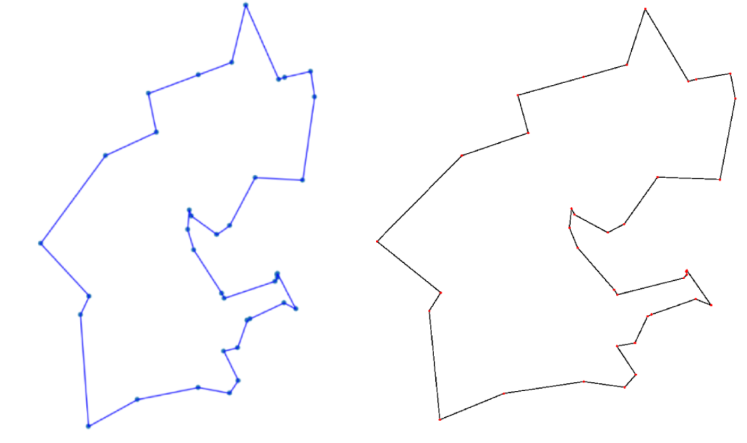

In [330]:
# A solution found with this genetic algorithm 
# was very similar to a optimal solution
Image(filename='solution.png') 